In [1]:
import pandas as pd
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [30]:
data = pd.read_csv("train.csv")
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Note:
datetime - hourly date + timestamp  
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals

# Data Preparation

Cleaning up the date format:

In [31]:
data['datetime'] = pd.to_datetime(data.datetime)
data.loc[:, 'date'] = data['datetime'].dt.date


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
date          10886 non-null object
dtypes: datetime64[ns](1), float64(3), int64(8), object(1)
memory usage: 1.1+ MB


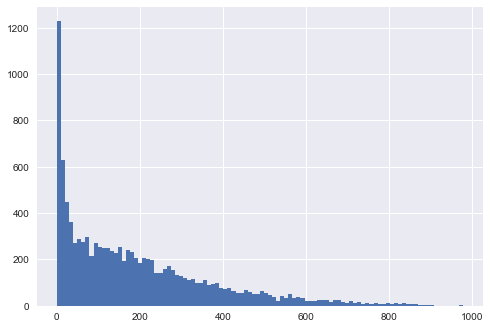

In [11]:
plt.hist(data['count'], bins = 100)
plt.show()

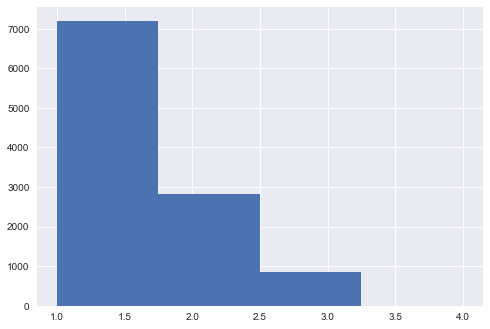

In [16]:
plt.hist(data['weather'], bins = 4)
plt.show()

In [17]:
data.groupby('weather').count()

,datetime,season,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count
weather,,,,,,,,,,,
1,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192
2,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834
3,859,859,859,859,859,859,859,859,859,859,859
4,1,1,1,1,1,1,1,1,1,1,1


In [18]:
data[data['weather'] == 4] #interesting... only one hour from all the data is classified as 4 for the weather

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164


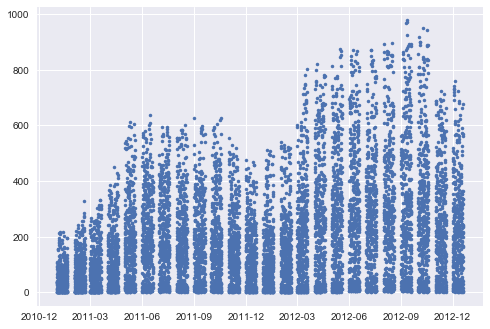

In [35]:
plt.plot(data.date.grouby(, data['count'], '.', label='train')
plt.show()